In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
import numpy as np
from tqdm import tqdm
import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import random
import math
from torchmetrics.image.fid import FrechetInceptionDistance
from IPython.display import Image

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

data_path = '/scratch/arjun.dosajh/DiffusionDataset/' # I renamed the Samples/ directory to DiffusionDataset/

# Visualising data

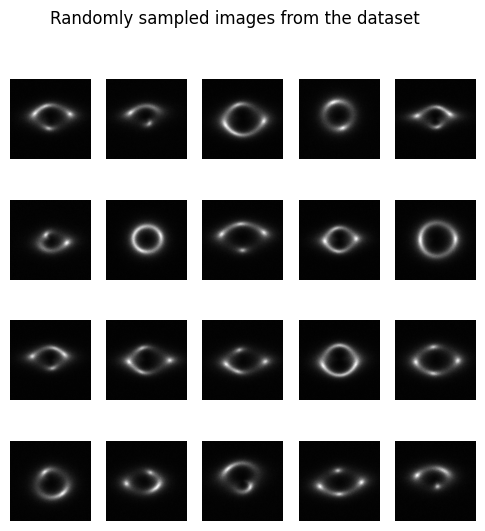

In [2]:
random_indices = np.random.randint(1, 10000, 20)
random_images_paths = np.array([data_path + 'sample' + str(i) + '.npy' for i in random_indices])
random_images = np.array([np.load(i) for i in random_images_paths])

def plot_images(images, description):
    """
    Plot a grid of images dynamically using the dimensions of the input array
    """
    if isinstance(images, torch.Tensor):
        images = images.cpu().numpy()
    images = images.transpose((0, 2, 3, 1))
    num_images = images.shape[0]

    num_cols = math.ceil(math.sqrt(num_images))
    num_rows = math.floor(math.sqrt(num_images))

    if num_rows * num_cols < num_images:
        num_rows += 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6, 6))
    fig.suptitle(description)

    for img, ax in zip(images, axes.flatten()):
        if images.shape[-1] == 1:
            ax.imshow(img.squeeze(), cmap='gray')
        else:
            ax.imshow(img.squeeze())
        ax.axis('off')

    if num_images < num_rows * num_cols:
        for ax in axes.flatten()[num_images:]:
            ax.axis('off')

    plt.show()

plot_images(random_images, 'Randomly sampled images from the dataset')

### Images are normalised to `[0, 1]`, we will need to normalise to `[-1, 1]`

In [3]:
np.min(random_images[0]), np.max(random_images[0])

(0.0, 1.0)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

        file_list = os.listdir(data_path)

        self.images = [np.load(os.path.join(self.data_path, file)) for file in tqdm(file_list, desc="Loading images")]
        if self.transform:
            self.images = [self.transform(image) for image in tqdm(self.images, desc="Applying transform")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [5]:
dataset = ImageDataset(data_path, transform=lambda x: (x - 0.5) * 2.0)
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=10)

Loading images:   0%|          | 48/10000 [00:00<01:01, 160.52it/s]

Applying transform: 100%|██████████| 10000/10000 [00:01<00:00, 6829.92it/s]


### Images are now normalised to `[-1, 1]`

In [6]:
dataset[0].min(), dataset[0].max(), dataset[0].shape

(-1.0, 1.0, (1, 150, 150))

In [7]:
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 28, 28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        return self.network(x, t)

In [8]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch
        plot_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            plot_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [9]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=150, w=150, generate_gif=False):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint) if generate_gif else []
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                x = x + sigma_t * z

            if generate_gif and (idx in frame_idxs or t == 0):
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                frames.append(frame)

    if generate_gif:
        with imageio.get_writer(gif_name, mode="I") as writer:
            for idx, frame in enumerate(frames):
                rgb_frame = np.repeat(frame, 3, axis=2)
                writer.append_data(rgb_frame)

                if idx == len(frames) - 1:
                    last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
                    for _ in range(frames_per_gif // 3):
                        writer.append_data(last_rgb_frame)
    return x

# UNet
### I have implemented 2 UNet models, the main difference is in the kernel size of the convolutional layers, the first model `MyUNet` uses a smaller kernel size than the second model `MyUNet2`

In [10]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [11]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [12]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 150, 150), 1, 10),
            MyBlock((10, 150, 150), 10, 10),
            MyBlock((10, 150, 150), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 75, 75), 10, 20),
            MyBlock((20, 75, 75), 20, 20),
            MyBlock((20, 75, 75), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 37, 37), 20, 40),
            MyBlock((40, 37, 37), 40, 40),
            MyBlock((40, 37, 37), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 18, 18), 40, 20),
            MyBlock((20, 18, 18), 20, 20),
            MyBlock((20, 18, 18), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 37, 37), 80, 40),
            MyBlock((40, 37, 37), 40, 20),
            MyBlock((20, 37, 37), 20, 20)
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(20, 20, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(20, 20, 2, 1)
        )
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 75, 75), 40, 20),
            MyBlock((20, 75, 75), 20, 10),
            MyBlock((10, 75, 75), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 150, 150), 20, 10),
            MyBlock((10, 150, 150), 10, 10),
            MyBlock((10, 150, 150), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 150, 150)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 75, 75)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 37, 37)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 18, 18)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 37, 37)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 37, 37)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 75, 75)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 75, 75)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 150, 150)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 150, 150)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [13]:
class MyUNet2(nn.Module):
    """
    MyUNet2 uses a bigger kernel than MyUNet (10 instead of 4)
    """
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet2, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 150, 150), 1, 10),
            MyBlock((10, 150, 150), 10, 10),
            MyBlock((10, 150, 150), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 10, 2, 4) # kernel is 10 here, in MyUNet it was 4

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 75, 75), 10, 20),
            MyBlock((20, 75, 75), 20, 20),
            MyBlock((20, 75, 75), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 10, 2, 4)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 37, 37), 20, 40),
            MyBlock((40, 37, 37), 40, 40),
            MyBlock((40, 37, 37), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 10, 2, 4)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 18, 18), 40, 20),
            MyBlock((20, 18, 18), 20, 20),
            MyBlock((20, 18, 18), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 10, 2, 4),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 37, 37), 80, 40),
            MyBlock((40, 37, 37), 40, 20),
            MyBlock((20, 37, 37), 20, 20)
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(20, 20, 10, 2, 4),
            nn.SiLU(),
            nn.ConvTranspose2d(20, 20, 2, 1)
        )
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 75, 75), 40, 20),
            MyBlock((20, 75, 75), 20, 10),
            MyBlock((10, 75, 75), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 10, 2, 4)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 150, 150), 20, 10),
            MyBlock((10, 150, 150), 10, 10),
            MyBlock((10, 150, 150), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 150, 150)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 75, 75)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 37, 37)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 18, 18)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 37, 37)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 37, 37)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 75, 75)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 75, 75)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 150, 150)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 150, 150)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [14]:
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors (https://arxiv.org/abs/2006.11239)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
ddpm2 = MyDDPM(MyUNet2(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

## Visualising Noised images

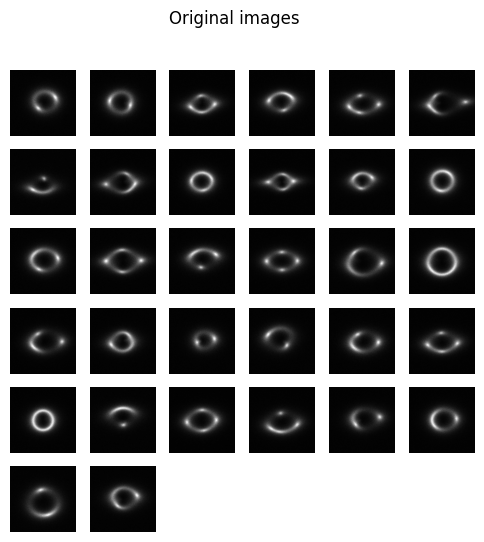

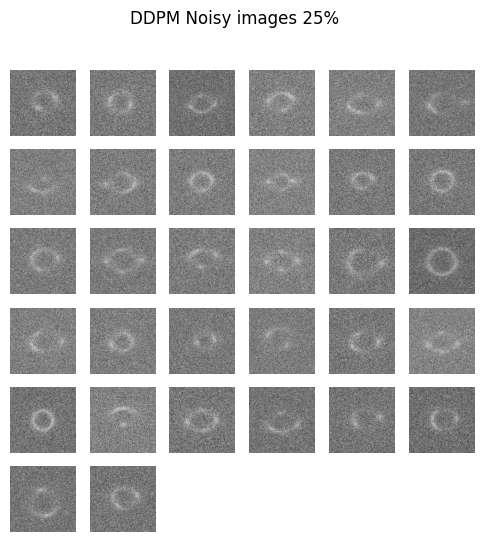

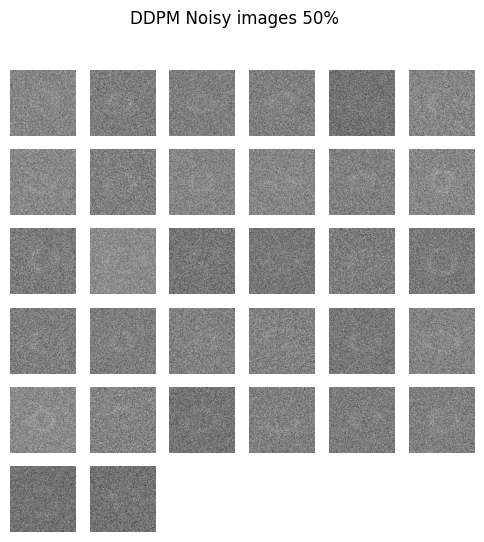

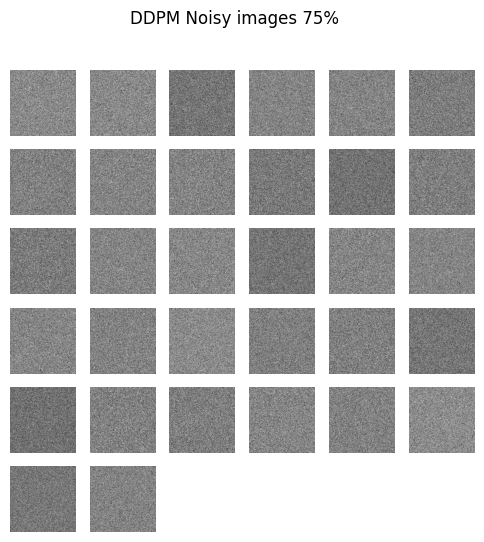

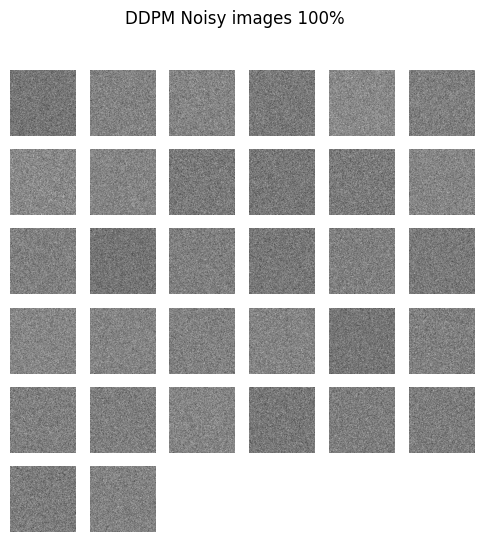

In [15]:
show_forward(ddpm, loader, device)

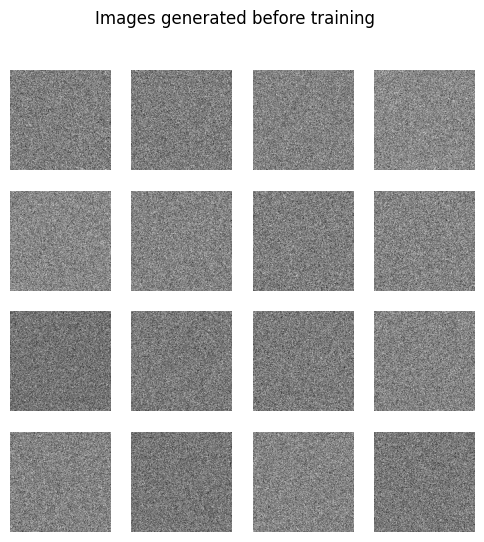

In [16]:
generated = generate_new_images(ddpm, gif_name="before_training.gif")
plot_images(generated, "Images generated before training")

In [17]:
def training_loop(ddpm, loader, n_epochs, optim, display=False):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}")):
            x0 = batch.to(device).float()
            n = len(x0)

            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            noisy_imgs = ddpm(x0, t, eta)

            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        if display:
            plot_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        print(f"Epoch {epoch + 1}/{n_epochs} - Loss: {epoch_loss:.3f}")

        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), 'ckpts/best_model_2.pth')
            print("Best model saved at epoch ", epoch)

In [ ]:
training_loop(ddpm, loader, n_epochs=100, optim=Adam(ddpm.parameters(), lr=0.001))

Epoch 1/100: 100%|██████████| 313/313 [00:19<00:00, 16.39it/s]


Epoch 1/100 - Loss: 0.139
Best model saved at epoch  0


Epoch 2/100: 100%|██████████| 313/313 [00:19<00:00, 16.01it/s]


Epoch 2/100 - Loss: 0.015
Best model saved at epoch  1


Epoch 3/100: 100%|██████████| 313/313 [00:19<00:00, 16.04it/s]


Epoch 3/100 - Loss: 0.008
Best model saved at epoch  2


Epoch 4/100: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


Epoch 4/100 - Loss: 0.008
Best model saved at epoch  3


Epoch 5/100: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 5/100 - Loss: 0.008


Epoch 6/100: 100%|██████████| 313/313 [00:20<00:00, 15.62it/s]


Epoch 6/100 - Loss: 0.007
Best model saved at epoch  5


Epoch 7/100: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 7/100 - Loss: 0.006
Best model saved at epoch  6


Epoch 8/100: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 8/100 - Loss: 0.006


Epoch 9/100: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 9/100 - Loss: 0.006


Epoch 10/100: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 10/100 - Loss: 0.006
Best model saved at epoch  9


Epoch 11/100: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 11/100 - Loss: 0.006


Epoch 12/100: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 12/100 - Loss: 0.006
Best model saved at epoch  11


Epoch 13/100: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 13/100 - Loss: 0.006


Epoch 14/100: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 14/100 - Loss: 0.006


Epoch 15/100: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 15/100 - Loss: 0.006


Epoch 16/100: 100%|██████████| 313/313 [00:19<00:00, 15.85it/s]


Epoch 16/100 - Loss: 0.006
Best model saved at epoch  15


Epoch 17/100: 100%|██████████| 313/313 [00:19<00:00, 15.96it/s]


Epoch 17/100 - Loss: 0.006


Epoch 18/100: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 18/100 - Loss: 0.005
Best model saved at epoch  17


Epoch 19/100: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 19/100 - Loss: 0.007


Epoch 20/100: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 20/100 - Loss: 0.006


Epoch 21/100: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 21/100 - Loss: 0.006


Epoch 22/100: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 22/100 - Loss: 0.006


Epoch 23/100: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 23/100 - Loss: 0.006


Epoch 24/100: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]


Epoch 24/100 - Loss: 0.016


Epoch 25/100: 100%|██████████| 313/313 [00:19<00:00, 15.77it/s]


Epoch 25/100 - Loss: 0.006


Epoch 26/100: 100%|██████████| 313/313 [00:19<00:00, 15.69it/s]


Epoch 26/100 - Loss: 0.006


Epoch 27/100: 100%|██████████| 313/313 [00:19<00:00, 15.90it/s]


Epoch 27/100 - Loss: 0.006


Epoch 28/100: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 28/100 - Loss: 0.005


Epoch 29/100: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]


Epoch 29/100 - Loss: 0.005
Best model saved at epoch  28


Epoch 30/100: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 30/100 - Loss: 0.006


Epoch 31/100: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 31/100 - Loss: 0.005


Epoch 32/100: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 32/100 - Loss: 0.005


Epoch 33/100: 100%|██████████| 313/313 [00:19<00:00, 15.73it/s]


Epoch 33/100 - Loss: 0.005


Epoch 34/100: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 34/100 - Loss: 0.005


Epoch 35/100: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 35/100 - Loss: 0.005
Best model saved at epoch  34


Epoch 36/100: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 36/100 - Loss: 0.005


Epoch 37/100: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 37/100 - Loss: 0.005


Epoch 38/100: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Epoch 38/100 - Loss: 0.005


Epoch 39/100: 100%|██████████| 313/313 [00:19<00:00, 15.88it/s]


Epoch 39/100 - Loss: 0.005
Best model saved at epoch  38


Epoch 40/100: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 40/100 - Loss: 0.005


Epoch 41/100: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Epoch 41/100 - Loss: 0.005


Epoch 42/100: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


Epoch 42/100 - Loss: 0.005


Epoch 43/100: 100%|██████████| 313/313 [00:20<00:00, 15.64it/s]


Epoch 43/100 - Loss: 0.004
Best model saved at epoch  42


Epoch 44/100: 100%|██████████| 313/313 [00:19<00:00, 15.70it/s]


Epoch 44/100 - Loss: 0.005


Epoch 45/100: 100%|██████████| 313/313 [00:20<00:00, 15.63it/s]


Epoch 45/100 - Loss: 0.005


Epoch 46/100: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 46/100 - Loss: 0.006


Epoch 47/100: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 47/100 - Loss: 0.005


Epoch 48/100: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]


Epoch 48/100 - Loss: 0.005


Epoch 49/100: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 49/100 - Loss: 0.005


Epoch 50/100: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Epoch 50/100 - Loss: 0.005


Epoch 51/100: 100%|██████████| 313/313 [00:19<00:00, 15.91it/s]


Epoch 51/100 - Loss: 0.005


Epoch 52/100: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 52/100 - Loss: 0.005


Epoch 53/100: 100%|██████████| 313/313 [00:19<00:00, 15.73it/s]


Epoch 53/100 - Loss: 0.005


Epoch 54/100: 100%|██████████| 313/313 [00:19<00:00, 15.70it/s]


Epoch 54/100 - Loss: 0.005


Epoch 55/100: 100%|██████████| 313/313 [00:20<00:00, 15.61it/s]


Epoch 55/100 - Loss: 0.005


Epoch 56/100: 100%|██████████| 313/313 [00:20<00:00, 15.58it/s]


Epoch 56/100 - Loss: 0.005


Epoch 57/100: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 57/100 - Loss: 0.004
Best model saved at epoch  56


Epoch 58/100: 100%|██████████| 313/313 [00:20<00:00, 15.64it/s]


Epoch 58/100 - Loss: 0.005


Epoch 59/100: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 59/100 - Loss: 0.005


Epoch 60/100: 100%|██████████| 313/313 [00:19<00:00, 15.66it/s]


Epoch 60/100 - Loss: 0.005


Epoch 61/100: 100%|██████████| 313/313 [00:20<00:00, 15.65it/s]


Epoch 61/100 - Loss: 0.005


Epoch 62/100: 100%|██████████| 313/313 [00:19<00:00, 15.67it/s]


Epoch 62/100 - Loss: 0.005


Epoch 63/100: 100%|██████████| 313/313 [00:19<00:00, 15.83it/s]


Epoch 63/100 - Loss: 0.005


Epoch 64/100: 100%|██████████| 313/313 [00:19<00:00, 15.74it/s]


Epoch 64/100 - Loss: 0.005


Epoch 65/100: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 65/100 - Loss: 0.006


Epoch 66/100: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 66/100 - Loss: 0.005


Epoch 67/100: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 67/100 - Loss: 0.005


Epoch 68/100: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 68/100 - Loss: 0.005


Epoch 69/100: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 69/100 - Loss: 0.005


Epoch 70/100: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 70/100 - Loss: 0.005


Epoch 71/100: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 71/100 - Loss: 0.004
Best model saved at epoch  70


Epoch 72/100: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 72/100 - Loss: 0.005


Epoch 73/100: 100%|██████████| 313/313 [00:19<00:00, 15.68it/s]


Epoch 73/100 - Loss: 0.005


Epoch 74/100: 100%|██████████| 313/313 [00:19<00:00, 15.72it/s]


Epoch 74/100 - Loss: 0.005


Epoch 75/100: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


Epoch 75/100 - Loss: 0.005


Epoch 76/100: 100%|██████████| 313/313 [00:19<00:00, 15.99it/s]


Epoch 76/100 - Loss: 0.005


Epoch 77/100: 100%|██████████| 313/313 [00:19<00:00, 15.81it/s]


Epoch 77/100 - Loss: 0.005


Epoch 78/100: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 78/100 - Loss: 0.005


Epoch 79/100: 100%|██████████| 313/313 [00:19<00:00, 15.80it/s]


Epoch 79/100 - Loss: 0.005


Epoch 80/100: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Epoch 80/100 - Loss: 0.005


Epoch 81/100: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]


Epoch 81/100 - Loss: 0.005


Epoch 82/100: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 82/100 - Loss: 0.004
Best model saved at epoch  81


Epoch 83/100: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 83/100 - Loss: 0.005


Epoch 84/100: 100%|██████████| 313/313 [00:19<00:00, 15.87it/s]


Epoch 84/100 - Loss: 0.005


Epoch 85/100: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 85/100 - Loss: 0.005


Epoch 86/100: 100%|██████████| 313/313 [00:19<00:00, 15.79it/s]


Epoch 86/100 - Loss: 0.004
Best model saved at epoch  85


Epoch 87/100: 100%|██████████| 313/313 [00:19<00:00, 15.75it/s]


Epoch 87/100 - Loss: 0.005


Epoch 88/100: 100%|██████████| 313/313 [00:19<00:00, 15.71it/s]


Epoch 88/100 - Loss: 0.005


Epoch 89/100: 100%|██████████| 313/313 [00:19<00:00, 15.84it/s]


Epoch 89/100 - Loss: 0.005


Epoch 90/100: 100%|██████████| 313/313 [00:19<00:00, 15.86it/s]


Epoch 90/100 - Loss: 0.005


Epoch 91/100: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 91/100 - Loss: 0.005


Epoch 92/100: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 92/100 - Loss: 0.005


Epoch 93/100: 100%|██████████| 313/313 [00:19<00:00, 15.82it/s]


Epoch 93/100 - Loss: 0.005


Epoch 94/100: 100%|██████████| 313/313 [00:19<00:00, 15.98it/s]


Epoch 94/100 - Loss: 0.005


Epoch 95/100: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 95/100 - Loss: 0.005


Epoch 96/100: 100%|██████████| 313/313 [00:19<00:00, 16.03it/s]


Epoch 96/100 - Loss: 0.005


Epoch 97/100: 100%|██████████| 313/313 [00:19<00:00, 15.93it/s]


Epoch 97/100 - Loss: 0.006


Epoch 98/100: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]


Epoch 98/100 - Loss: 0.005


Epoch 99/100: 100%|██████████| 313/313 [00:19<00:00, 15.89it/s]


Epoch 99/100 - Loss: 0.005


Epoch 100/100: 100%|██████████| 313/313 [00:19<00:00, 15.92it/s]

Epoch 100/100 - Loss: 0.005


In [18]:
training_loop(ddpm2, loader, n_epochs=100, optim=Adam(ddpm2.parameters(), lr=0.001))

Epoch 1/100: 100%|██████████| 313/313 [00:38<00:00,  8.20it/s]


Epoch 1/100 - Loss: 0.131
Best model saved at epoch  0


Epoch 2/100: 100%|██████████| 313/313 [00:37<00:00,  8.31it/s]


Epoch 2/100 - Loss: 0.015
Best model saved at epoch  1


Epoch 3/100: 100%|██████████| 313/313 [00:37<00:00,  8.30it/s]


Epoch 3/100 - Loss: 0.009
Best model saved at epoch  2


Epoch 4/100: 100%|██████████| 313/313 [00:37<00:00,  8.25it/s]


Epoch 4/100 - Loss: 0.008
Best model saved at epoch  3


Epoch 5/100: 100%|██████████| 313/313 [00:38<00:00,  8.20it/s]


Epoch 5/100 - Loss: 0.007
Best model saved at epoch  4


Epoch 6/100: 100%|██████████| 313/313 [00:38<00:00,  8.16it/s]


Epoch 6/100 - Loss: 0.007
Best model saved at epoch  5


Epoch 7/100: 100%|██████████| 313/313 [00:38<00:00,  8.08it/s]


Epoch 7/100 - Loss: 0.006
Best model saved at epoch  6


Epoch 8/100: 100%|██████████| 313/313 [00:39<00:00,  8.03it/s]


Epoch 8/100 - Loss: 0.006


Epoch 9/100: 100%|██████████| 313/313 [00:38<00:00,  8.05it/s]


Epoch 9/100 - Loss: 0.006


Epoch 10/100: 100%|██████████| 313/313 [00:38<00:00,  8.06it/s]


Epoch 10/100 - Loss: 0.006
Best model saved at epoch  9


Epoch 11/100: 100%|██████████| 313/313 [00:38<00:00,  8.04it/s]


Epoch 11/100 - Loss: 0.006


Epoch 12/100: 100%|██████████| 313/313 [00:39<00:00,  8.01it/s]


Epoch 12/100 - Loss: 0.006


Epoch 13/100: 100%|██████████| 313/313 [00:38<00:00,  8.04it/s]


Epoch 13/100 - Loss: 0.006
Best model saved at epoch  12


Epoch 14/100: 100%|██████████| 313/313 [00:38<00:00,  8.07it/s]


Epoch 14/100 - Loss: 0.006


Epoch 15/100: 100%|██████████| 313/313 [00:38<00:00,  8.09it/s]


Epoch 15/100 - Loss: 0.006
Best model saved at epoch  14


Epoch 16/100: 100%|██████████| 313/313 [00:39<00:00,  7.97it/s]


Epoch 16/100 - Loss: 0.006
Best model saved at epoch  15


Epoch 17/100: 100%|██████████| 313/313 [00:38<00:00,  8.03it/s]


Epoch 17/100 - Loss: 0.006


Epoch 18/100: 100%|██████████| 313/313 [00:39<00:00,  8.01it/s]


Epoch 18/100 - Loss: 0.007


Epoch 19/100: 100%|██████████| 313/313 [00:39<00:00,  8.03it/s]


Epoch 19/100 - Loss: 0.006
Best model saved at epoch  18


Epoch 20/100: 100%|██████████| 313/313 [00:39<00:00,  8.01it/s]


Epoch 20/100 - Loss: 0.006


Epoch 21/100: 100%|██████████| 313/313 [00:39<00:00,  8.02it/s]


Epoch 21/100 - Loss: 0.006
Best model saved at epoch  20


Epoch 22/100: 100%|██████████| 313/313 [00:38<00:00,  8.08it/s]


Epoch 22/100 - Loss: 0.005
Best model saved at epoch  21


Epoch 23/100: 100%|██████████| 313/313 [00:38<00:00,  8.12it/s]


Epoch 23/100 - Loss: 0.005
Best model saved at epoch  22


Epoch 24/100: 100%|██████████| 313/313 [00:38<00:00,  8.14it/s]


Epoch 24/100 - Loss: 0.005


Epoch 25/100: 100%|██████████| 313/313 [00:38<00:00,  8.10it/s]


Epoch 25/100 - Loss: 0.006


Epoch 26/100: 100%|██████████| 313/313 [00:38<00:00,  8.10it/s]


Epoch 26/100 - Loss: 0.005


Epoch 27/100: 100%|██████████| 313/313 [00:38<00:00,  8.11it/s]


Epoch 27/100 - Loss: 0.005


Epoch 28/100: 100%|██████████| 313/313 [00:38<00:00,  8.10it/s]


Epoch 28/100 - Loss: 0.006


Epoch 29/100: 100%|██████████| 313/313 [00:38<00:00,  8.09it/s]


Epoch 29/100 - Loss: 0.005


Epoch 30/100: 100%|██████████| 313/313 [00:38<00:00,  8.09it/s]


Epoch 30/100 - Loss: 0.005


Epoch 31/100: 100%|██████████| 313/313 [00:38<00:00,  8.08it/s]


Epoch 31/100 - Loss: 0.005


Epoch 32/100: 100%|██████████| 313/313 [00:38<00:00,  8.08it/s]


Epoch 32/100 - Loss: 0.005


Epoch 33/100: 100%|██████████| 313/313 [00:38<00:00,  8.06it/s]


Epoch 33/100 - Loss: 0.012


Epoch 34/100: 100%|██████████| 313/313 [00:38<00:00,  8.03it/s]


Epoch 34/100 - Loss: 0.007


Epoch 35/100: 100%|██████████| 313/313 [00:39<00:00,  8.02it/s]


Epoch 35/100 - Loss: 0.006


Epoch 36/100: 100%|██████████| 313/313 [00:38<00:00,  8.08it/s]


Epoch 36/100 - Loss: 0.007


Epoch 37/100: 100%|██████████| 313/313 [00:38<00:00,  8.03it/s]


Epoch 37/100 - Loss: 0.006


Epoch 38/100: 100%|██████████| 313/313 [00:38<00:00,  8.05it/s]


Epoch 38/100 - Loss: 0.005


Epoch 39/100: 100%|██████████| 313/313 [00:39<00:00,  8.01it/s]


Epoch 39/100 - Loss: 0.006


Epoch 40/100: 100%|██████████| 313/313 [00:21<00:00, 14.59it/s]


Epoch 40/100 - Loss: 0.005


Epoch 41/100: 100%|██████████| 313/313 [00:21<00:00, 14.67it/s]


Epoch 41/100 - Loss: 0.006


Epoch 42/100: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


Epoch 42/100 - Loss: 0.006


Epoch 43/100: 100%|██████████| 313/313 [00:21<00:00, 14.79it/s]


Epoch 43/100 - Loss: 0.006


Epoch 44/100: 100%|██████████| 313/313 [00:21<00:00, 14.64it/s]


Epoch 44/100 - Loss: 0.006


Epoch 45/100: 100%|██████████| 313/313 [00:21<00:00, 14.63it/s]


Epoch 45/100 - Loss: 0.005


Epoch 46/100: 100%|██████████| 313/313 [00:21<00:00, 14.74it/s]


Epoch 46/100 - Loss: 0.005


Epoch 47/100: 100%|██████████| 313/313 [00:21<00:00, 14.51it/s]


Epoch 47/100 - Loss: 0.006


Epoch 48/100: 100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


Epoch 48/100 - Loss: 0.006


Epoch 49/100: 100%|██████████| 313/313 [00:21<00:00, 14.76it/s]


Epoch 49/100 - Loss: 0.005


Epoch 50/100: 100%|██████████| 313/313 [00:21<00:00, 14.73it/s]


Epoch 50/100 - Loss: 0.005


Epoch 51/100: 100%|██████████| 313/313 [00:21<00:00, 14.55it/s]


Epoch 51/100 - Loss: 0.005


Epoch 52/100: 100%|██████████| 313/313 [00:21<00:00, 14.88it/s]


Epoch 52/100 - Loss: 0.005


Epoch 53/100: 100%|██████████| 313/313 [00:21<00:00, 14.84it/s]


Epoch 53/100 - Loss: 0.005
Best model saved at epoch  52


Epoch 54/100: 100%|██████████| 313/313 [00:21<00:00, 14.75it/s]


Epoch 54/100 - Loss: 0.005


Epoch 55/100: 100%|██████████| 313/313 [00:21<00:00, 14.54it/s]


Epoch 55/100 - Loss: 0.005


Epoch 56/100: 100%|██████████| 313/313 [00:21<00:00, 14.82it/s]


Epoch 56/100 - Loss: 0.005


Epoch 57/100: 100%|██████████| 313/313 [00:21<00:00, 14.74it/s]


Epoch 57/100 - Loss: 0.006


Epoch 58/100: 100%|██████████| 313/313 [00:20<00:00, 14.94it/s]


Epoch 58/100 - Loss: 0.005


Epoch 59/100: 100%|██████████| 313/313 [00:21<00:00, 14.58it/s]


Epoch 59/100 - Loss: 0.005


Epoch 60/100: 100%|██████████| 313/313 [00:21<00:00, 14.62it/s]


Epoch 60/100 - Loss: 0.005


Epoch 61/100: 100%|██████████| 313/313 [00:21<00:00, 14.60it/s]


Epoch 61/100 - Loss: 0.005


Epoch 62/100: 100%|██████████| 313/313 [00:21<00:00, 14.85it/s]


Epoch 62/100 - Loss: 0.005


Epoch 63/100: 100%|██████████| 313/313 [00:21<00:00, 14.59it/s]


Epoch 63/100 - Loss: 0.005


Epoch 64/100: 100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


Epoch 64/100 - Loss: 0.005


Epoch 65/100: 100%|██████████| 313/313 [00:21<00:00, 14.56it/s]


Epoch 65/100 - Loss: 0.005


Epoch 66/100: 100%|██████████| 313/313 [00:21<00:00, 14.71it/s]


Epoch 66/100 - Loss: 0.005


Epoch 67/100: 100%|██████████| 313/313 [00:21<00:00, 14.59it/s]


Epoch 67/100 - Loss: 0.005


Epoch 68/100: 100%|██████████| 313/313 [00:20<00:00, 14.97it/s]


Epoch 68/100 - Loss: 0.005


Epoch 69/100: 100%|██████████| 313/313 [00:20<00:00, 14.95it/s]


Epoch 69/100 - Loss: 0.005


Epoch 70/100: 100%|██████████| 313/313 [00:21<00:00, 14.82it/s]


Epoch 70/100 - Loss: 0.005


Epoch 71/100: 100%|██████████| 313/313 [00:21<00:00, 14.72it/s]


Epoch 71/100 - Loss: 0.005


Epoch 72/100: 100%|██████████| 313/313 [00:20<00:00, 14.91it/s]


Epoch 72/100 - Loss: 0.005


Epoch 73/100: 100%|██████████| 313/313 [00:21<00:00, 14.69it/s]


Epoch 73/100 - Loss: 0.005
Best model saved at epoch  72


Epoch 74/100: 100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


Epoch 74/100 - Loss: 0.005


Epoch 75/100: 100%|██████████| 313/313 [00:20<00:00, 15.18it/s]


Epoch 75/100 - Loss: 0.005
Best model saved at epoch  74


Epoch 76/100: 100%|██████████| 313/313 [00:21<00:00, 14.85it/s]


Epoch 76/100 - Loss: 0.005


Epoch 77/100: 100%|██████████| 313/313 [00:20<00:00, 14.93it/s]


Epoch 77/100 - Loss: 0.005


Epoch 78/100: 100%|██████████| 313/313 [00:21<00:00, 14.85it/s]


Epoch 78/100 - Loss: 0.004
Best model saved at epoch  77


Epoch 79/100: 100%|██████████| 313/313 [00:21<00:00, 14.76it/s]


Epoch 79/100 - Loss: 0.005


Epoch 80/100: 100%|██████████| 313/313 [00:21<00:00, 14.64it/s]


Epoch 80/100 - Loss: 0.005


Epoch 81/100: 100%|██████████| 313/313 [00:21<00:00, 14.65it/s]


Epoch 81/100 - Loss: 0.005


Epoch 82/100: 100%|██████████| 313/313 [00:20<00:00, 15.12it/s]


Epoch 82/100 - Loss: 0.005


Epoch 83/100: 100%|██████████| 313/313 [00:21<00:00, 14.67it/s]


Epoch 83/100 - Loss: 0.005


Epoch 84/100: 100%|██████████| 313/313 [00:21<00:00, 14.61it/s]


Epoch 84/100 - Loss: 0.005


Epoch 85/100: 100%|██████████| 313/313 [00:21<00:00, 14.72it/s]


Epoch 85/100 - Loss: 0.005


Epoch 86/100: 100%|██████████| 313/313 [00:21<00:00, 14.69it/s]


Epoch 86/100 - Loss: 0.006


Epoch 87/100: 100%|██████████| 313/313 [00:21<00:00, 14.80it/s]


Epoch 87/100 - Loss: 0.005


Epoch 88/100: 100%|██████████| 313/313 [00:21<00:00, 14.70it/s]


Epoch 88/100 - Loss: 0.005


Epoch 89/100: 100%|██████████| 313/313 [00:21<00:00, 14.78it/s]


Epoch 89/100 - Loss: 0.005


Epoch 90/100: 100%|██████████| 313/313 [00:21<00:00, 14.82it/s]


Epoch 90/100 - Loss: 0.005


Epoch 91/100: 100%|██████████| 313/313 [00:21<00:00, 14.83it/s]


Epoch 91/100 - Loss: 0.004


Epoch 92/100: 100%|██████████| 313/313 [00:20<00:00, 14.94it/s]


Epoch 92/100 - Loss: 0.005


Epoch 93/100: 100%|██████████| 313/313 [00:21<00:00, 14.73it/s]


Epoch 93/100 - Loss: 0.005


Epoch 94/100: 100%|██████████| 313/313 [00:21<00:00, 14.77it/s]


Epoch 94/100 - Loss: 0.005


Epoch 95/100: 100%|██████████| 313/313 [00:21<00:00, 14.65it/s]


Epoch 95/100 - Loss: 0.005


Epoch 96/100: 100%|██████████| 313/313 [00:21<00:00, 14.70it/s]


Epoch 96/100 - Loss: 0.005


Epoch 97/100: 100%|██████████| 313/313 [00:21<00:00, 14.58it/s]


Epoch 97/100 - Loss: 0.005


Epoch 98/100: 100%|██████████| 313/313 [00:21<00:00, 14.87it/s]


Epoch 98/100 - Loss: 0.005


Epoch 99/100: 100%|██████████| 313/313 [00:21<00:00, 14.60it/s]


Epoch 99/100 - Loss: 0.005


Epoch 100/100: 100%|██████████| 313/313 [00:21<00:00, 14.59it/s]


Epoch 100/100 - Loss: 0.004
Best model saved at epoch  99


In [18]:
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model2 = MyDDPM(MyUNet2(), n_steps=n_steps, device=device)

best_model.load_state_dict(torch.load('ckpts/best_model_1.pth', map_location=device))
best_model2.load_state_dict(torch.load('ckpts/best_model_2.pth', map_location=device))

best_model.eval()
best_model2.eval()

print("Models loaded")

Models loaded


Generating new images (MyUNet)


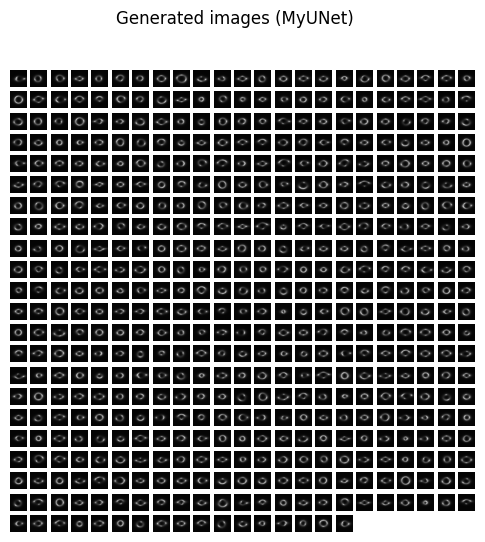

In [19]:
print("Generating new images (MyUNet)")
generated = generate_new_images(
        best_model,
        n_samples=500,
        device=device,
        gif_name="lensing.gif",
        generate_gif=False
    )
plot_images(generated, description="Generated images (MyUNet)")

Generating new images (MyUNet2)


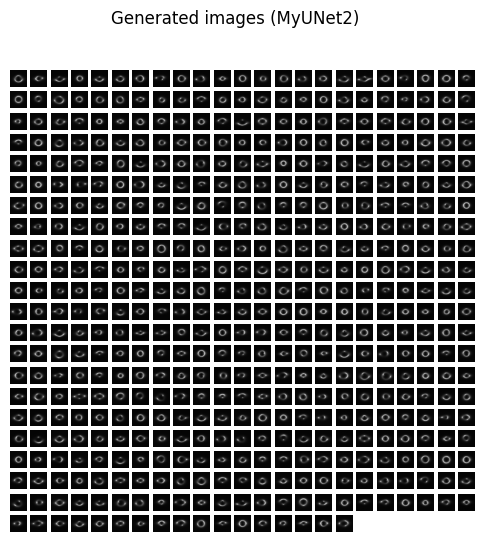

In [20]:
print("Generating new images (MyUNet2)")
generated_2 = generate_new_images(
        best_model2,
        n_samples=500,
        device=device,
        gif_name="lensing_2.gif",
        generate_gif=False
    )
plot_images(generated_2, description="Generated images (MyUNet2)")

# Quantitatively evaluating generated images using FID Score

In [21]:
def prepare_fid_data(dataset, generated):
    generated = generated.cpu().numpy()

    mn, mx = np.min(generated), np.max(generated)

    generated -= mn
    generated /= (mx - mn)

    real = np.array(dataset[:generated.shape[0]])
    real = (real / 2) + 0.5 # denormalize to (0, 1)
    real = real.astype(np.float32)

    return real, generated

real, generated = prepare_fid_data(dataset, generated)
real, generated_2 = prepare_fid_data(dataset, generated_2)

real.shape, generated.shape

((500, 1, 150, 150), (500, 1, 150, 150))

### The Fréchet Inception V3 Distance (FID) score is a widely used metric for evaluating the quality and realism of generated images, particularly in the context of Generative Adversarial Networks (GANs). The FID score relies on the Inception V3 model, a deep convolutional neural network pre-trained on the ImageNet dataset. The Inception V3 model has been trained on images of dimension `(3, 299, 299)`, expecting RGB images with three color channels. However, in our case, the generated images and the original images used for comparison have dimensions `(1, 150, 150)` in grayscale format.

### To calculate the FID score using the pre-trained Inception V3 model, it is necessary to interpolate the images to match the expected input dimensions of the model. This interpolation process involves `resizing` the images to (299, 299) and `expanding` the single-channel grayscale images to three-channel RGB images by replicating the single channel across all three color channels. By performing this interpolation, the images are transformed to a format compatible with the Inception V3 model, enabling the calculation of the FID score for evaluating the quality of the generated images.

### FID score implementation uses the Inception V3 model which was trained on images of dimensions (3, 299, 299), so we need to resize and expand our images. We expand simply by duplicating the single color channel and resizing is done automatically by the torchmetrics function: FrechetInceptionDistance

In [22]:
def expand_images(real, generated):
    real_images_expanded = np.repeat(real, 3, axis=1)
    generated_images_expanded = np.repeat(generated, 3, axis=1)

    real_images_expanded = (real_images_expanded * 255).astype(np.uint8)
    generated_images_expanded = (generated_images_expanded * 255).astype(np.uint8)

    return real_images_expanded, generated_images_expanded

real_images_expanded, generated_images_expanded_1 = expand_images(real, generated)
real_images_expanded, generated_images_expanded_2 = expand_images(real, generated_2)

generated_images_expanded_1.shape, real_images_expanded.shape

((500, 3, 150, 150), (500, 3, 150, 150))

In [23]:
def calculate_FID(real_images_expanded, generated_images_expanded):
    fid = FrechetInceptionDistance(feature=64)
    real_images_expanded_tensor = torch.tensor(real_images_expanded, dtype=torch.uint8)
    generated_images_expanded_tensor = torch.tensor(generated_images_expanded, dtype=torch.uint8)
    fid.update(real_images_expanded_tensor, real=True)
    fid.update(generated_images_expanded_tensor, real=False)
    FID_score = fid.compute()
    return FID_score

FID_score_1 = calculate_FID(real_images_expanded, generated_images_expanded_1)
FID_score_2 = calculate_FID(real_images_expanded, generated_images_expanded_2)

print("FID Score (MyUNet) = ", FID_score_1.item())
print("FID Score (MyUNet2) = ", FID_score_2.item())

FID Score (MyUNet) =  18.9255428314209
FID Score (MyUNet2) =  15.425938606262207


## Qualitatively evaluating the generated images

Generating new images using first model


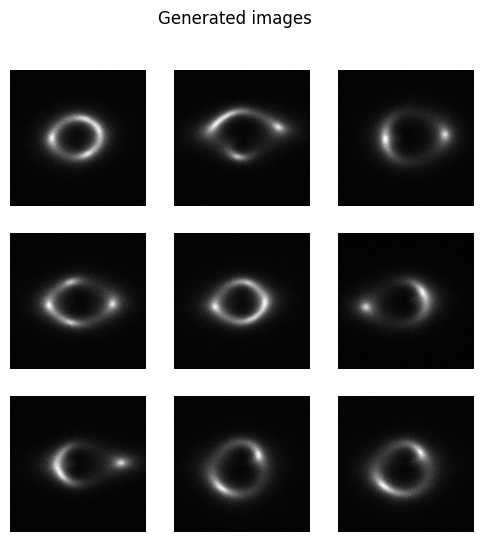

In [24]:
print("Generating new images using first model")
generated = generate_new_images(
        best_model,
        n_samples=9,
        device=device,
        gif_name="lensing.gif",
        generate_gif=False
    )
plot_images(generated, description="Generated images")

Generating new images using second model


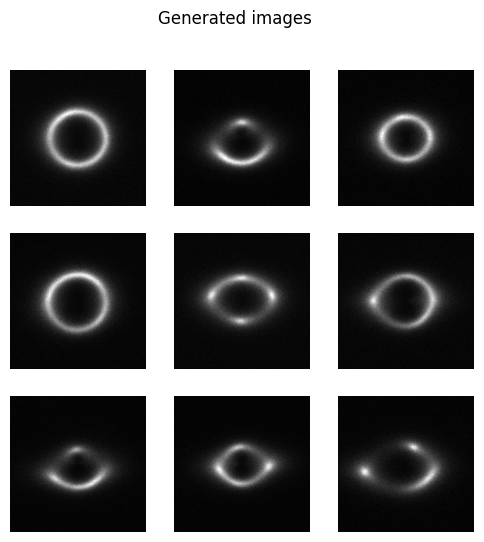

In [25]:
print("Generating new images using second model")
generated = generate_new_images(
        best_model2,
        n_samples=9,
        device=device,
        gif_name="lensing.gif",
        generate_gif=False
    )
plot_images(generated, description="Generated images")

# We can see qualitatively that the generated images are very similar to the real images

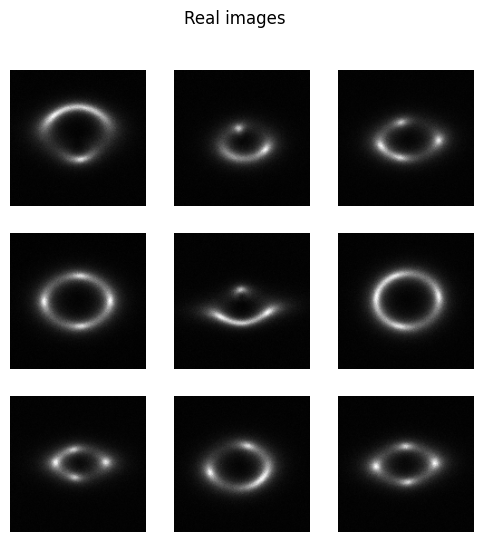

In [26]:
real_images = np.array(dataset[:generated.shape[0]])
real_images = (real_images / 2) + 0.5 # denormalize to (0, 1)
real_images = real_images.astype(np.float32)

plot_images(real_images, description="Real images")

# Uncomment the following cell and run it to visualise image generation starting from noise

In [27]:
# Image(open('lensing.gif','rb').read())